In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import itertools
import utils_gbi as utils
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
from IPython.display import Image

## Inputs

In [2]:
# investment environment
W0 = 1.0
C = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05, 0.0] 
year = 10
goal = 2.5


# portfolio constraints
ratio_min = 0.02  # minimum asset ratio
ratio_max = 0.3  # maximum asset ratio

# algorithm settings
portfolio_choice = 15  # num of portfolios
grid_gap = 0.01  # wealth grid density
z = 3  # wealth grid significance level

# input data
# mean = np.load('mean.npy')
# cov = np.load('cov.npy')
# number of asset
# num_of_assets = mean.shape[1]
#print(mean)
#print(cov)



f = open('return_mon_b.csv', 'r', newline='', encoding='utf-8-sig')
rd = csv.reader(f)
return_temp = []
for i in rd:
    # print(i)
    return_temp.append(float(i[1]))
f.close()

num_of_assets = len(return_temp)

f = open('cov_mon_b.csv', 'r', newline='', encoding='utf-8-sig')
rd = csv.reader(f)
cov_temp = []
for i in rd:
    temp = []

    for j in i:
        temp.append(float(j))
    cov_temp.append(temp)

# print(cov_temp)
# print(len(cov_temp))

mean = []
cov = []

mean.append(return_temp)
cov.append(cov_temp)

for i in range(year-1):
    mean.append(return_temp)
    cov.append(cov_temp)
    # mean.append( (np.asarray(mean[-1])*1.1).tolist() )
    # cov.append( (np.asarray(cov[-1])*1.1).tolist() )

mean = np.asarray(mean)
cov = np.asarray(cov)

In [3]:
# mean = np.array([mean[0].tolist()]*year)
# cov = np.array([cov[0].tolist()]*year)

## Efficient Frontier 생성 

Text(0.5, 0, 'standard deviation')

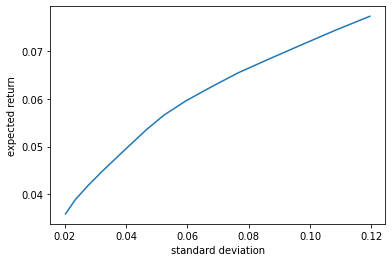

In [4]:
mu, sigma, portfolio = utils.portfolio_generate(mean, cov, year, ratio_min, ratio_max, portfolio_choice, 1)
plt.plot(sigma[1],mu[1])
plt.ylabel('expected return')
plt.xlabel('standard deviation')

#  

# 1. Original GBI

## Grid 생성

In [5]:
number_of_grid, wealth_grid = utils.generate_grid(mu,sigma,W0,C,year,z,grid_gap)
print(wealth_grid[-1,[0,-1]],goal) # goal이 [wealth_min, wealth_max]에 포함되어야함

[0.69 8.62] 2.5


## GBI의 해 (최적 확률, 최적 전략)

In [6]:
cur_time = time.time()
transition_prob, optimal_value, optimal_strategy, Q = utils.solve_gbi(year,number_of_grid,mu,sigma,C,wealth_grid,goal,portfolio_choice)
print('probability: ',optimal_value[0,0],'/ time:', time.time() - cur_time, 's')

probability:  0.8259300229214752 / time: 1.6699533462524414 s


## State Probability

In [7]:
state_probability = utils.state_probability(year,number_of_grid,optimal_strategy,transition_prob,wealth_grid)

## Glide Path

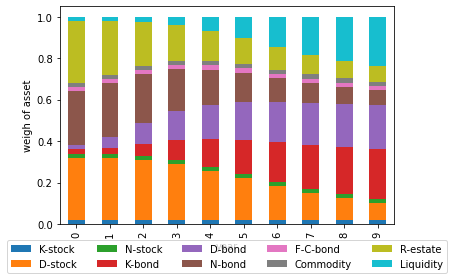

In [8]:
glide_path = utils.glide_pathglide_path = utils.glide_path(year,num_of_assets,portfolio,optimal_strategy,number_of_grid,state_probability)

In [9]:
## Investment Ratio

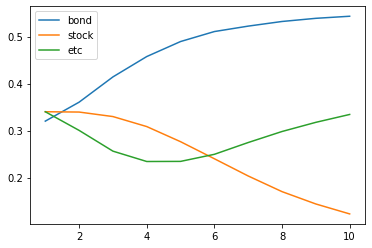

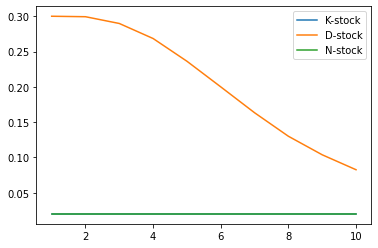

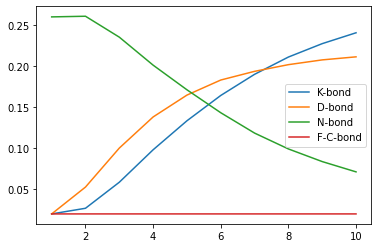

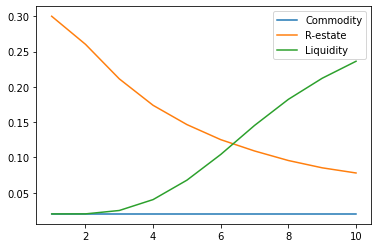

In [10]:
stock_ratio = glide_path[:,0] + glide_path[:,1] + glide_path[:,2]
bond_ratio = glide_path[:,3] + glide_path[:,4] + glide_path[:,5] + glide_path[:,6]
etc_ratio = glide_path[:,7] + glide_path[:,8] + glide_path[:,9]

plt.plot(range(1,year+1), bond_ratio, label='bond')
plt.plot(range(1,year+1), stock_ratio, label='stock')
plt.plot(range(1,year+1), etc_ratio, label='etc')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path[:,0], label='K-stock')
plt.plot(range(1,year+1), glide_path[:,1], label='D-stock')
plt.plot(range(1,year+1), glide_path[:,2], label='N-stock')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path[:,3], label='K-bond')
plt.plot(range(1,year+1), glide_path[:,4], label='D-bond')
plt.plot(range(1,year+1), glide_path[:,5], label='N-bond')
plt.plot(range(1,year+1), glide_path[:,6], label='F-C-bond')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path[:,7], label='Commodity')
plt.plot(range(1,year+1), glide_path[:,8], label='R-estate')
plt.plot(range(1,year+1), glide_path[:,9], label='Liquidity')
plt.legend()
plt.show()

## Final Wealth Distribution

goal =  2.5


Text(0.5, 0, 'wealth')

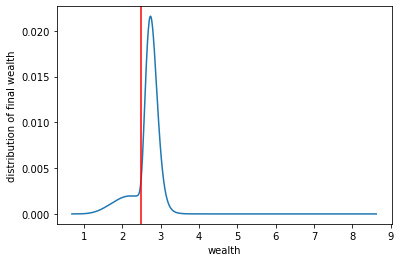

In [11]:
t=1
plt.plot(wealth_grid[-t,:number_of_grid[-t]],state_probability[-t,:number_of_grid[-t]])
plt.axvline(x=goal,c='r')
print('goal = ',goal)
plt.ylabel('distribution of final wealth')
plt.xlabel('wealth')

#  

# 2. Goal-Level for Target Probability

## Inputs

In [12]:
target_prob = 0.7
max_iter_bs = 100

## Bisection Method: Target Goal-level

In [13]:
cur_time = time.time()

min_bs = goal
max_bs = wealth_grid[-1][-1]

for _iter in range(max_iter_bs):
    
    if (max_bs-min_bs)<grid_gap: break
    
    mid_bs = (min_bs+max_bs)/2
    
    _, value_bs, _, _ =utils.solve_gbi(year,number_of_grid,mu,sigma,C,wealth_grid,mid_bs,portfolio_choice)
    
    if value_bs[0,0]>=target_prob: min_bs = mid_bs
    else: max_bs = mid_bs    

print('Goal-level for target probability: ',min_bs,'/ time:', time.time() - cur_time, 's')

Goal-level for target probability:  2.798828125 / time: 15.31300163269043 s


#  

# 3. 중간시점 이전까지 최적포트폴리오보다 k단계 위험한 포트폴리오 선택시

## Inputs

In [14]:
target_prob = 0.8
max_iter_bs = 20

## Bisection Method: Optimal k for Target Probability

In [15]:
cur_time = time.time()

min_bs = 0
max_bs = portfolio_choice-1

for _iter in range(max_iter_bs):
    
    if (max_bs<=min_bs+0.5): break
    
    mid_bs = np.ceil((min_bs+max_bs)/2).astype(int)
    
    state_prob_bs = utils.state_probability(year,number_of_grid,np.clip(optimal_strategy[:]+mid_bs,0,portfolio_choice-1),transition_prob,wealth_grid)
        
    if state_prob_bs[-1][np.where(wealth_grid[-1]+C[-1]>=goal)].sum()>=target_prob: min_bs = mid_bs
    else: max_bs = mid_bs    

k_opt = min_bs
print('Optimal k for target probability: ',k_opt,'/ time:', time.time() - cur_time, 's')

Optimal k for target probability:  7 / time: 0.2798738479614258 s


## State Probability for Optimal k

In [16]:
optimal_strategy_rev_k_opt = np.clip(optimal_strategy[:]+k_opt,0,portfolio_choice-1)
state_probability_rev_k_opt = utils.state_probability(year,number_of_grid,optimal_strategy_rev_k_opt,transition_prob,wealth_grid)

## 목표 도달 확률

In [17]:
state_probability_rev_k_opt[-1][np.where(wealth_grid[-1]+C[-1]>=goal)].sum()

0.8014908014726956

## Glide Path

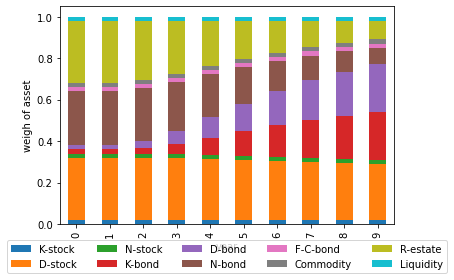

In [18]:
glide_path_rev_k_opt = utils.glide_path(year,num_of_assets,portfolio,optimal_strategy_rev_k_opt,number_of_grid,state_probability_rev_k_opt)

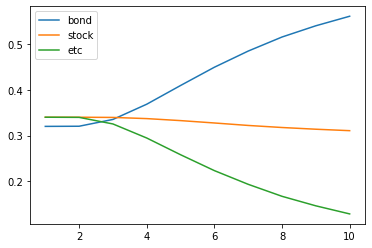

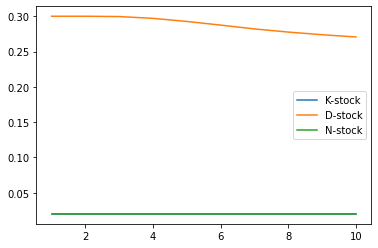

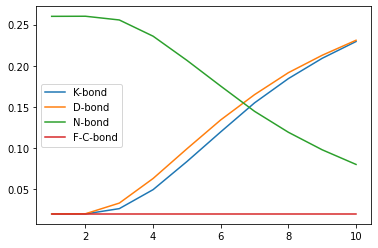

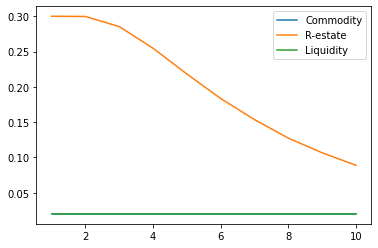

In [19]:
stock_ratio = glide_path_rev_k_opt[:,0] + glide_path_rev_k_opt[:,1] + glide_path_rev_k_opt[:,2]
bond_ratio = glide_path_rev_k_opt[:,3] + glide_path_rev_k_opt[:,4] + glide_path_rev_k_opt[:,5] + glide_path_rev_k_opt[:,6]
etc_ratio = glide_path_rev_k_opt[:,7] + glide_path_rev_k_opt[:,8] + glide_path_rev_k_opt[:,9]

plt.plot(range(1,year+1), bond_ratio, label='bond')
plt.plot(range(1,year+1), stock_ratio, label='stock')
plt.plot(range(1,year+1), etc_ratio, label='etc')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path_rev_k_opt[:,0], label='K-stock')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,1], label='D-stock')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,2], label='N-stock')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path_rev_k_opt[:,3], label='K-bond')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,4], label='D-bond')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,5], label='N-bond')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,6], label='F-C-bond')
plt.legend()
plt.show()

plt.plot(range(1,year+1), glide_path_rev_k_opt[:,7], label='Commodity')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,8], label='R-estate')
plt.plot(range(1,year+1), glide_path_rev_k_opt[:,9], label='Liquidity')
plt.legend()
plt.show()

#  

# 4. k단계 위험한 포트폴리오 선택시, 목표확률을 이룰수 있는 중간 인출 금액

## Inputs

In [20]:
target_prob = 0.7
years_withdrawal = [3,7]
k = 0
max_iter_bs = 20

In [21]:
optimal_strategy_rev_k = np.clip(optimal_strategy[:]+k,0,portfolio_choice-1)

## Bisection Method: Optimal Withdrawal for Target Probability

In [22]:
cur_time = time.time()

min_bs = 0
max_bs = wealth_grid[min(years_withdrawal)][number_of_grid[min(years_withdrawal)]-1]

for _iter in range(max_iter_bs):
    
    if (max_bs-min_bs)<grid_gap: break
    
    mid_bs = (min_bs+max_bs)/2
    
    state_prob_bs =utils.state_probability_withdrawal(year,number_of_grid,optimal_strategy_rev_k,transition_prob,wealth_grid,grid_gap,years_withdrawal,mid_bs,target_prob)
    
    if state_prob_bs[-1][np.where(wealth_grid[-1]+C[-1]>=goal)].sum()>=target_prob: min_bs = mid_bs
    else: max_bs = mid_bs  

withdrawal_opt = min_bs
print('Withdrawal-level for target probability: ',withdrawal_opt,'/ time:', time.time() - cur_time, 's')

Withdrawal-level for target probability:  0.09281249999999999 / time: 0.14431023597717285 s


## 목표달성 확률

In [23]:
state_probability_withdrawal = utils.state_probability_withdrawal(year,number_of_grid,optimal_strategy_rev_k,transition_prob,wealth_grid,grid_gap,years_withdrawal,withdrawal_opt,target_prob)
state_probability_withdrawal[-1][np.where(wealth_grid[-1]+C[-1]>=goal)].sum()

0.7138226335652812

#  

# 5. 목표확률을 이룰수 있는 최적 중간 인출 금액

## Inputs

In [24]:
target_prob = 0.6
years_withdrawal = [3,7]
max_iter_bs = 20

## Bisection Method: Optimal Withdrawal for Target Probability

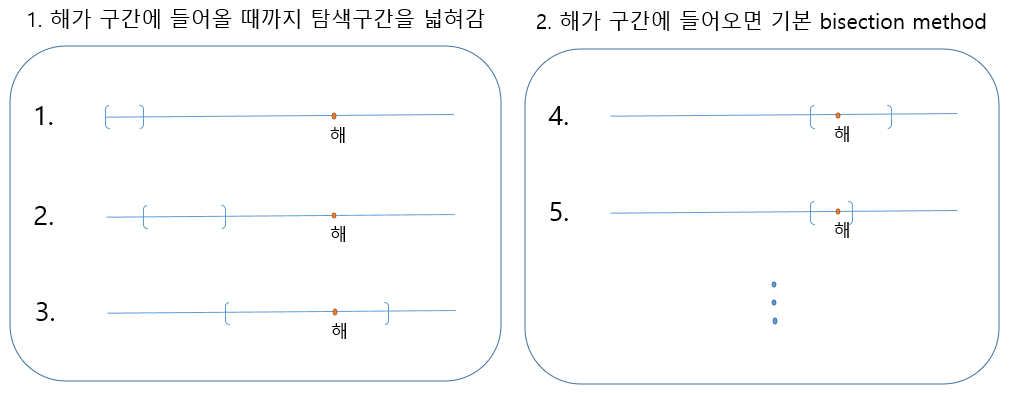

In [25]:
Image('image.png') # 해를 탐색할구간의 최대값을 모르므로 아래와 같은 방식으로 bisection method를 사용할 구간을 먼저 찾음

In [26]:
cur_time = time.time()

# 위 그림의 1번 과정
min_bs = 0
max_bs = 0.01
for _iter in range(max_iter_bs):
    
    C_new = np.array(C)
    C_new[years_withdrawal]-=max_bs    
    number_of_grid_tmp, wealth_grid_tmp = utils.generate_grid(mu,sigma,W0,C_new,year,z,grid_gap)
    transition_prob_tmp, optimal_value_tmp, optimal_strategy_tmp, Q_tmp = utils.solve_gbi(year,number_of_grid_tmp,mu,sigma,C_new,wealth_grid_tmp,goal,portfolio_choice)
    
    if optimal_value_tmp[0,0]<target_prob:
        print("해가 포함된 구간 찾음: [{},{}]".format(min_bs,max_bs))
        break
        
    else: # 탐색구간의 최댓값을 인출해도 확률이 target prob. 보다 높음: 해가 구간 밖이므로 구간을 넓힘
        min_bs = max_bs        
        max_bs *= 2
        
    if _iter==(max_iter_bs-1): print("해가 포함된 구간 못찾음")
        

# 위 그림의 2번 과정        
for _iter in range(max_iter_bs):
    
    # 해 찾고 bisection 종료
    if (max_bs-min_bs)<grid_gap: break 
    
    mid_bs = (min_bs+max_bs)/2
    
    # mid만큼 인출했을때의 확률 계산
    C_new = np.array(C)
    C_new[years_withdrawal]-=mid_bs    
    number_of_grid_tmp, wealth_grid_tmp = utils.generate_grid(mu,sigma,W0,C_new,year,z,grid_gap)
    transition_prob_tmp, optimal_value_tmp, optimal_strategy_tmp, Q_tmp = utils.solve_gbi(year,number_of_grid_tmp,mu,sigma,C_new,wealth_grid_tmp,goal,portfolio_choice)
    
    # 확률에 따라 탐색구간 조정
    if optimal_value_tmp[0,0]>=target_prob: min_bs = mid_bs
    else: max_bs = mid_bs 

# 뒤에 그래프 등 그릴때 사용할 최적 인출금상황에 대한 결과들
withdrawal_opt = min_bs
C_new = np.array(C)
C_new[years_withdrawal]-=withdrawal_opt   
number_of_grid_opt, wealth_grid_opt = utils.generate_grid(mu,sigma,W0,C_new,year,z,grid_gap)
transition_prob_opt, optimal_value_opt, optimal_strategy_opt, _ = utils.solve_gbi(year,number_of_grid_opt,mu,sigma,C_new,wealth_grid_opt,goal,portfolio_choice)

print('Withdrawal-level for target probability: ',withdrawal_opt,'/ time:', time.time() - cur_time, 's')

해가 포함된 구간 찾음: [0.16,0.32]
Withdrawal-level for target probability:  0.175 / time: 21.953670024871826 s
